# 필터의 가중치

- 입력 이미지의 2차원 영역에 적용되어 어떤 특징을 크게 두드러지게 표현하는 역할
    - 예) 물건의 테두리같은 특징적인 부분의 가중치는 높고 그 외 영역은 가중치가 낮게

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# 저장해둔 cnn모델 불러오기
model = keras.models.load_model("./model/best-cnn-model.h5")

In [3]:
# 모델 층 확인
model.layers

In [5]:
# 첫 번째 합성곱 층의 가중치 확인
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


- conv.weights[0]
    - 가중치
    - 가중치의 크기
        - 커널의 크기 : (3, 3, 1)
        - 필터의 개수 : 32
        
- conv.weights[1]
    - 절편의 개수 = 필터의 개수

In [7]:
# 원활한 계산을 위해서 넘파이 배열로 변환
conv_weights = conv.weights[0].numpy()

In [8]:
print(conv_weights.mean(), conv_weights.std())

-0.02138005 0.23590067


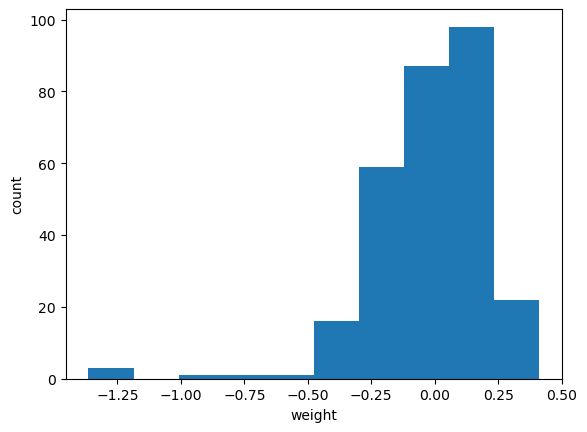

In [9]:
# 가중치 히스토그램
plt.figure()

plt.hist(conv_weights.reshape(-1, 1)) # hist함수는 데이터를 1차원 배열로 전달해야함

plt.xlabel("weight")
plt.ylabel("count")

plt.show()

- 0을 중심으로 종 모양으로 분포

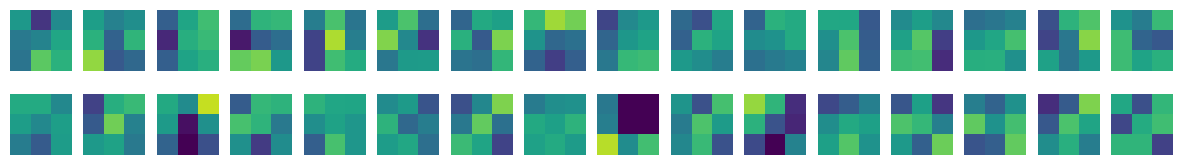

In [11]:
# 32개의 커널을 모두 시각화
fig, axs = plt.subplots(2, 16, figsize = (15, 2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:, :, 0, i * 16 + j], vmin = -0.5, vmax = 0.5)
        axs[i, j].axis("off")
plt.show()

- 밝은 부분이 높은 값
    - 가중치가 높은 영역에 이미지가 겹치면 크게 활성화됨
        - 예) 오른쪽 세로로 한 줄의 가중치가 높다면 오른쪽에 놓인 직선을 만나면 크게 활성화
        
- i : 행 인덱스(0 ~ 1)
- j : 열 인덱스(0 ~ 15)
    - conv_weights[:, :, 0, 0] 부터 conv_weights[:, :, 0, 31] 까지 출력
    
- imshow()
    - 배열의 최댓값과 최솟값으로 픽셀의 강도를 표현
        - 배열의 최댓값은 가장 밝은 색으로
        - 배열의 최솟값은 가장 어두운 색으로 표현
    - vmin, vmax
        - 컬러맵으로 표현할 색의 범위 지정

# 훈련하지 않은 빈 합성곱 신경망과 비교

In [12]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = "relu",
                                          padding = "same", input_shape = (28, 28, 1)))

In [13]:
# 훈련하지 않은 빈 합성곱 층의 가중치를 저장
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [14]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

-0.0051672217 0.08017684


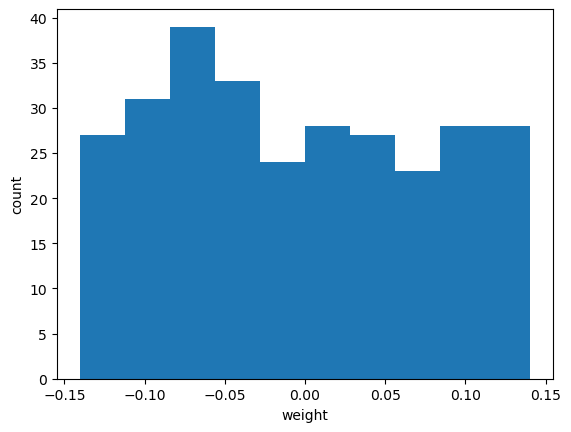

In [15]:
# 빈 합성곱 층 히스토그램
plt.figure()

plt.hist(no_training_weights.reshape(-1, 1))

plt.xlabel("weight")
plt.ylabel("count")

plt.show()

- 대부분의 가중치가 -0.15부터 0.15까지 고르게 분포함
    - 텐서플로에서 가중치를 초기화할 때 균등 분포에서 랜덤하게 값을 선택하기 때문에

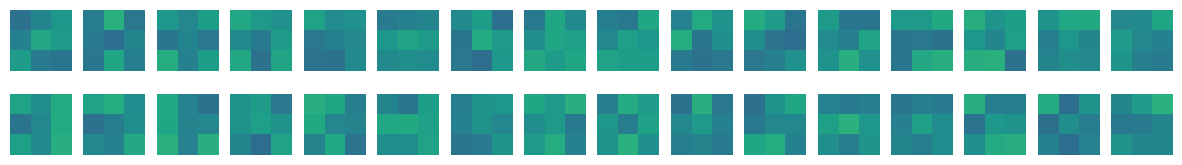

In [17]:
# 32개의 커널을 모두 시각화
fig, axs = plt.subplots(2, 16, figsize = (15, 2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:, :, 0, i * 16 + j], vmin = -0.5, vmax = 0.5)
        axs[i, j].axis("off")
plt.show()

- 훈련된 모델에 비해 패턴이 뚜렷하지 않음

# 케라스의 함수형  API

- Sequential 클래스 : 층을 차례대로 쌓은 단순한 모델을 구성
- 복잡한 모델은 구성하기 힘들기 때문에 함수형 API(functional API)를 사용
- 케라스의 Model 클래스를 사용하여 모델을 생성
- layers객체를 함수처럼 호출하여 동작

## 함수형 API로 다층 인공신경망 모델 구현 예제

In [18]:
# 입력층 생성
inputs = keras.Input(shape = (784,))

- Sequential 클래스는 InputLayer 클래스를 자동으로 추가하고 호출
- Model클래스는 입력층을 수동으로 만들어서 호출해야함

In [19]:
# 은닉층과 출력층 객체 생성
dense1 = keras.layers.Dense(100, activation = "sigmoid")
dense2 = keras.layers.Dense(10, activation = "softmax")

In [20]:
# 은닉층 호출
hidden = dense1(inputs)

- inputs를 Dense층에 통과시킨 후 출력값 hidden을 만드는 구조 생성

In [21]:
# 출력층 호출
outputs = dense2(hidden)

In [22]:
# Model클래스로  inputs와 outputs를 연결
test_model = keras.Model(inputs, outputs)

In [23]:
test_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


# 합성곱 신경망 모델 특성맵 시각화

- 함수형 API를 이용해 첫 번째 합성곱 층의 출력(특성맵)을 시각화

In [24]:
# 합성곱 모델의 입력
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


In [25]:
# 합성곱층과 입력층을 함수형 API로 연결
conv_acti = keras.Model(model.input, model.layers[0].output)

In [26]:
# 데이터 준비
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

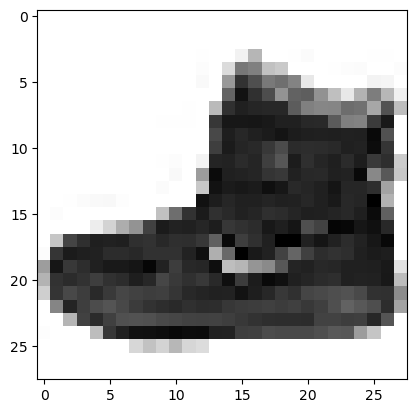

In [27]:
plt.figure()
plt.imshow(x_train[0], cmap = "gray_r")
plt.show()

In [29]:
# 위의 데이터를 첫 번째 합성곱 층에 통과
inputs = x_train[[0]].reshape(-1, 28, 28, 1) / 255

In [30]:
feature_maps = conv_acti.predict(inputs)

1/1 [==============================] - 2s 2s/step


In [31]:
print(feature_maps.shape)

(1, 28, 28, 32)


- 세임 패딩과 32개의 필터를 사용한 합성곱층의 출력이기 때문에 (28, 28, 32)
- 첫 번째 차원은 배치 차원
    - 샘플 하나만 입력했기 때문에 1

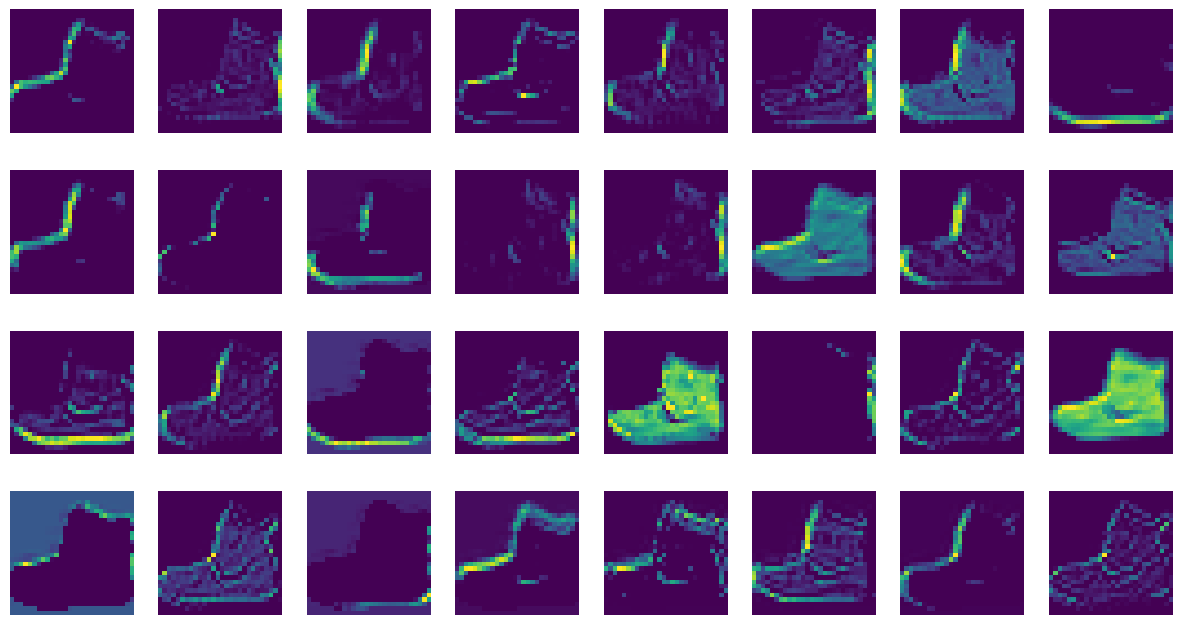

In [32]:
# 32개의 특성맵 시각화
fig, axs = plt.subplots(4, 8, figsize = (15, 8))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0, :, :, i * 8 + j])
        axs[i, j].axis("off")
plt.show()

- 32개의 필터로 인해 입력 이미지에서 강하게 활성화된 부분들을 시각화
    - 필터가 수직선을 감지한다면 수직선부분이 강하게 활성화
    - 전체적으로 모두 감지하는 필터는 아이템의 전체를 활성화
    - 전체적으로 음수값인 필터는 배경과 같은 0에 가까운 값과 곱해지면 작은 음수, 큰 수가 곱해지면 큰 음수가 됨
        - 배경을 잘 활성화함

In [33]:
# 두 번째 합성곱 층의 특성 맵 확인
conv2_acti = keras.Model(model.input, model.layers[2].output)

In [34]:
feature_maps = conv2_acti.predict(inputs)

1/1 [==============================] - 0s 191ms/step


In [35]:
print(feature_maps.shape)

(1, 14, 14, 64)


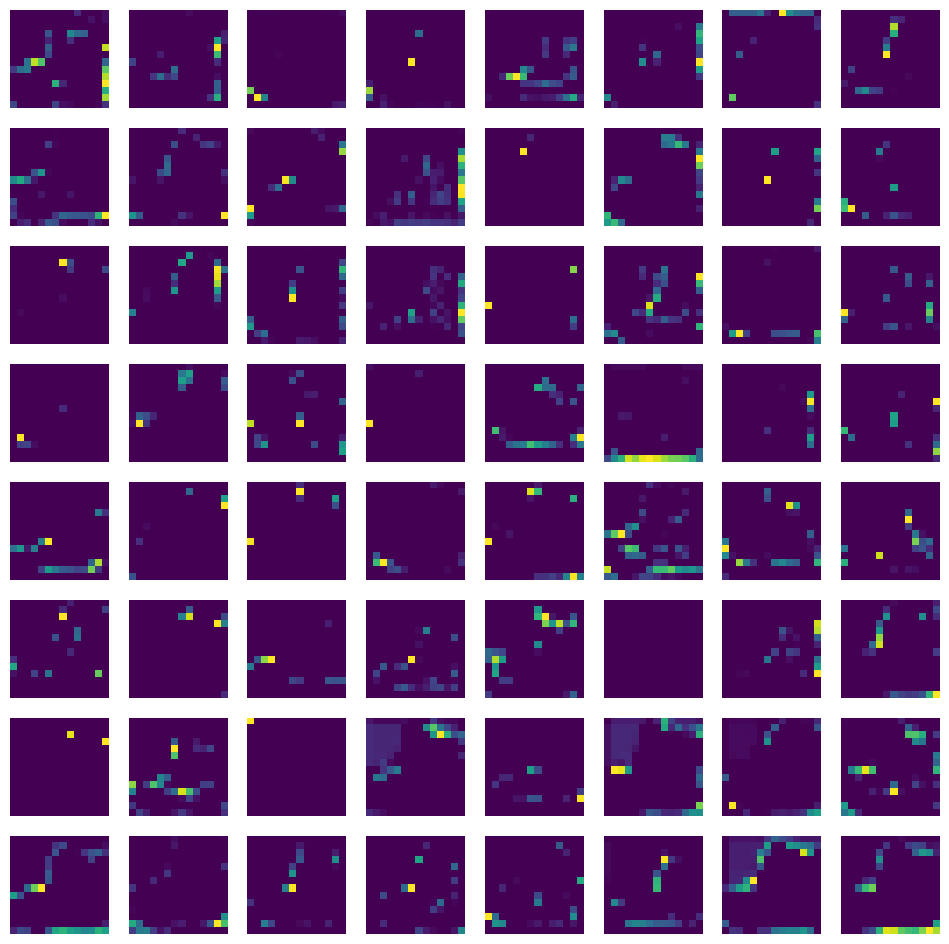

In [36]:
fig, axs = plt.subplots(8, 8, figsize = (12, 12))

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0, :, :, i * 8 + j])
        axs[i, j].axis("off")
plt.show()

- 특성맵을 시각적으로 이해하기 난해함
    - 합성곱층을 많이 쌓을수록 심해짐
    - 앞부분의 합성곱층은 이미지의 시각적인 정보를 감지하고
    - 뒷부분의 합성곱층은 앞쪽에서 감지한 시각적인 정보를 바탕으로 추상적인 정보를 학습

# 풀링 결과물 비교

In [37]:
pool_model = keras.Model(model.input, model.layers[1].output)

In [38]:
pool_feature_maps = pool_model.predict(inputs)

1/1 [==============================] - 0s 48ms/step


In [40]:
print(pool_feature_maps.shape)

(1, 14, 14, 32)


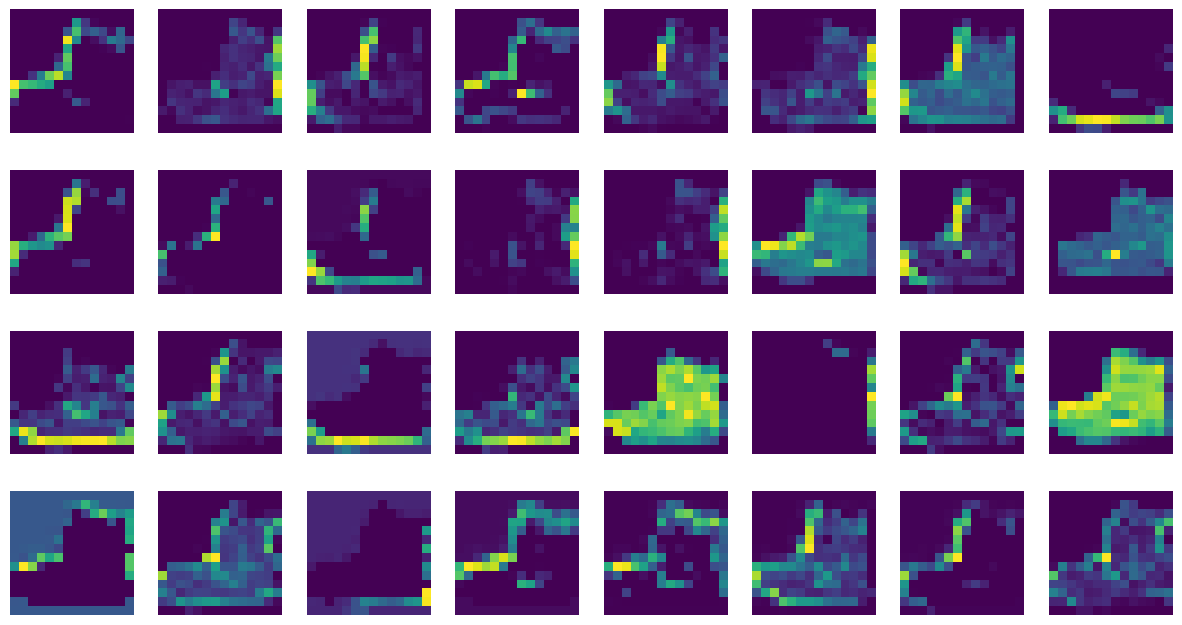

In [41]:
fig, axs = plt.subplots(4, 8, figsize = (15, 8))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(pool_feature_maps[0, :, :, i * 8 + j])
        axs[i, j].axis("off")
plt.show()